In [11]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from nltools.data import Brain_Data, Design_Matrix, Adjacency
import networkx as nx
from scipy import signal
from mne_connectivity import spectral_connectivity_epochs
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
from itertools import cycle
from matplotlib.lines import Line2D
from scipy.fft import fft, fftfreq
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from matplotlib.animation import FuncAnimation, PillowWriter
import plotly.graph_objs as go
from functools import reduce
import teneto
from teneto import TemporalNetwork





from functions.EpiIndex import *
from functions.Connectivity import *

In [2]:
raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_5.fif', preload=True)
#Reading a npy file 
data_alpha = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/segments_non_ictal/pte_01_connectivity_data_alpha_aec_dense.npy')
data_beta = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/segments_non_ictal/pte_01_connectivity_data_beta_aec_dense.npy')
data_hgamma = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/segments_non_ictal/pte_01_connectivity_data_high_gamma1_aec_dense.npy')
data_lgamma = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/segments_non_ictal/pte_01_connectivity_data_low_gamma_aec_dense.npy')
data_theta = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/segments_non_ictal/pte_01_connectivity_data_theta_aec_dense.npy')

data_alpha_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/segments_non_ictal/pte_01_connectivity_data_alpha_aec_distance_dense.npy')
data_beta_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/segments_non_ictal/pte_01_connectivity_data_beta_aec_distance_dense.npy')
data_hgamma_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/segments_non_ictal/pte_01_connectivity_data_high_gamma1_aec_distance_dense.npy')
data_lgamma_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/segments_non_ictal/pte_01_connectivity_data_low_gamma_aec_distance_dense.npy')
data_theta_norm = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/segments_non_ictal/pte_01_connectivity_data_theta_aec_distance_dense.npy')
# Reading the .tsv file 
xyz_loc = pd.read_csv('/home/pablo/works/dev_thesis_SEEG/data/pte_01/others/sEEG_locs_filtered.tsv', sep='\t')


#Data with other metrics
data_coh = np.load('/home/pablo/works/dev_thesis_SEEG/outputs/pte_01/SR_subseg_connectivity_data_high_freq_coh_dense.npy')[:,:,:,0]
# Assuming data is the array with shape (50, 127, 127)
for i in range(data_coh.shape[0]):
    # Extract the lower triangular part (including the diagonal)
    lower_triangular = np.tril(data_coh[i])
    
    # Mirror the lower triangular part to the upper triangular part
    data_coh[i] = lower_triangular + lower_triangular.T - np.diag(np.diag(lower_triangular))

#Make data_coh symmetric
#To know the index of the channels ["lp'11", "lp'12", "op'12", "pi'18", "pa'12"] in the raw object into an array
idx_channels = [raw.ch_names.index(ch) for ch in ["lp'11", "lp'12", "op'12", "pi'18", "pa'12"]]
#Eliminate from data_coh the channels that are not in the raw object
data_coh = np.delete(data_coh, idx_channels, axis=1)
data_coh = np.delete(data_coh, idx_channels, axis=2)
# con_data=np.mean(data,axis=3)
raw.drop_channels(["lp'11", "lp'12", "op'12", "pi'18", "pa'12"])

Opening raw data file /home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_5.fif...
Isotrak not found
    Range : 2546688 ... 2731008 =   4974.000 ...  5334.000 secs
Ready.


/tmp/ipykernel_476157/518937365.py:1: RuntimeWarning: This filename (/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_5.fif', preload=True)


Reading 0 ... 184320  =      0.000 ...   360.000 secs...


Measurement date,"May 20, 2024 02:11:21 GMT"
Experimenter,Unknown
Participant,Sara
Digitized points,Not available
Good channels,122 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.15 Hz
Lowpass,134.00 Hz


In [12]:
data=data_lgamma_norm
data=data.transpose(1,2,0)
tnet_bu= TemporalNetwork(N=data.shape[0],T=data.shape[2],nettype='wu',from_array=data,
                      timetype='discrete',timeunit='epoch', nodelabels=list(xyz_loc['formatted_label'].values))

tnet_bu.binarize(threshold_type='percent',threshold_level=0.10)

tnet_wu=TemporalNetwork(N=data.shape[0],T=data.shape[2],nettype='wu',from_array=data,
                      timetype='discrete',timeunit='epoch', nodelabels=list(xyz_loc['formatted_label'].values))


In [54]:
tnet_bu_ar=tnet_bu.network
communities_dict={}
for i in range(tnet_bu_ar.shape[2]):
    #Building a network using adjacency matrix
    adj = Adjacency(tnet_bu_ar[:,:,i],labels=raw.ch_names)
    G = adj.to_graph()
    communities_generator=nx.community.girvan_newman(G)
    next_level_communities = next(communities_generator)
    communities = sorted(map(sorted, next_level_communities))
    communities_dict[i]=communities

# Number of time steps
num_timesteps = len(communities_dict)

# Number of channels
num_channels = len(raw.ch_names)

# Initialize an array for each time step (2D list) with default value -1 (indicating no community yet)
output = [[-1 for _ in range(num_timesteps)] for _ in range(num_channels)]



# Iterate through the communities dictionary
for t, subcommunities in communities_dict.items():
    # Loop through each subcommunity and assign its index to the respective channels
    for subcom_idx, subcommunity in enumerate(subcommunities):
        for channel in subcommunity:
            # Find the index of the channel in ch_names
            if channel in raw.ch_names:
                channel_idx = raw.ch_names.index(channel)
                # Assign the subcommunity index to the correct channel
                output[channel_idx][t] = subcom_idx

In [70]:
#Making temporal consensus
communities_after=teneto.communitydetection.make_temporal_consensus(output)

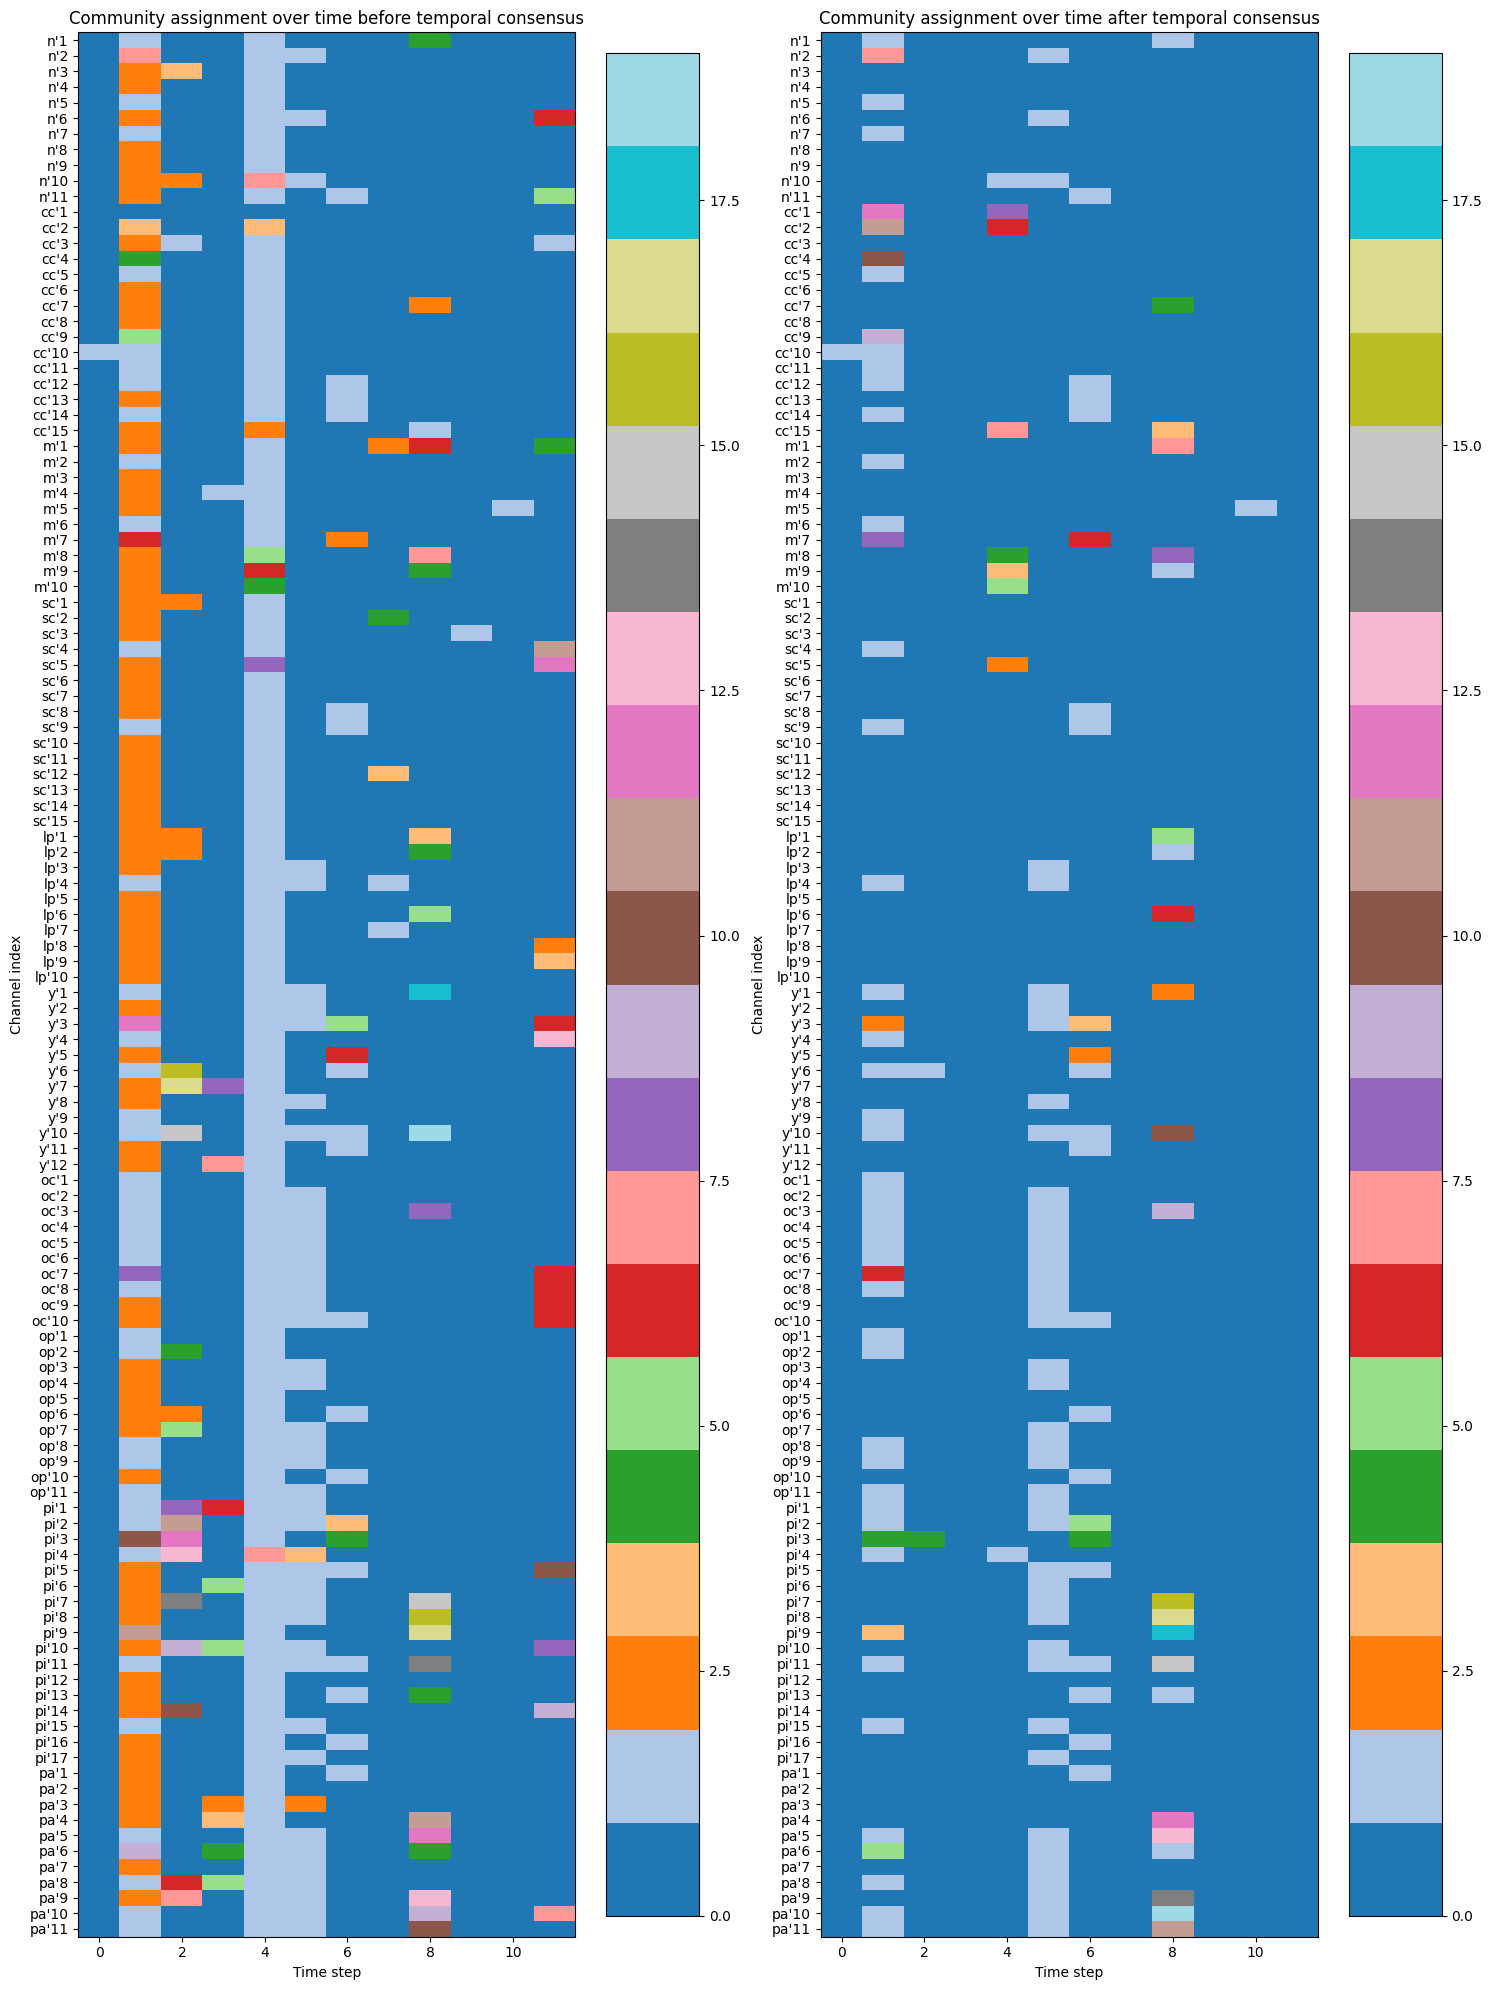

In [74]:
#Compare the communities
fig, axes = plt.subplots(1, 2, figsize=(15, 20))

# Plot for 'Community assignment over time before temporal consensus'
im1 = axes[0].imshow(output, aspect='auto', cmap='tab20')
axes[0].set_xlabel('Time step')
axes[0].set_ylabel('Channel index')
axes[0].set_title('Community assignment over time before temporal consensus')
axes[0].set_yticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1))
axes[0].set_yticklabels(xyz_loc['formatted_label'].values)
fig.colorbar(im1, ax=axes[0])

# Plot for 'Community assignment over time after temporal consensus'
im2 = axes[1].imshow(communities_after, aspect='auto', cmap='tab20')
axes[1].set_xlabel('Time step')
axes[1].set_ylabel('Channel index')
axes[1].set_title('Community assignment over time after temporal consensus')
axes[1].set_yticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1))
axes[1].set_yticklabels(xyz_loc['formatted_label'].values)
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

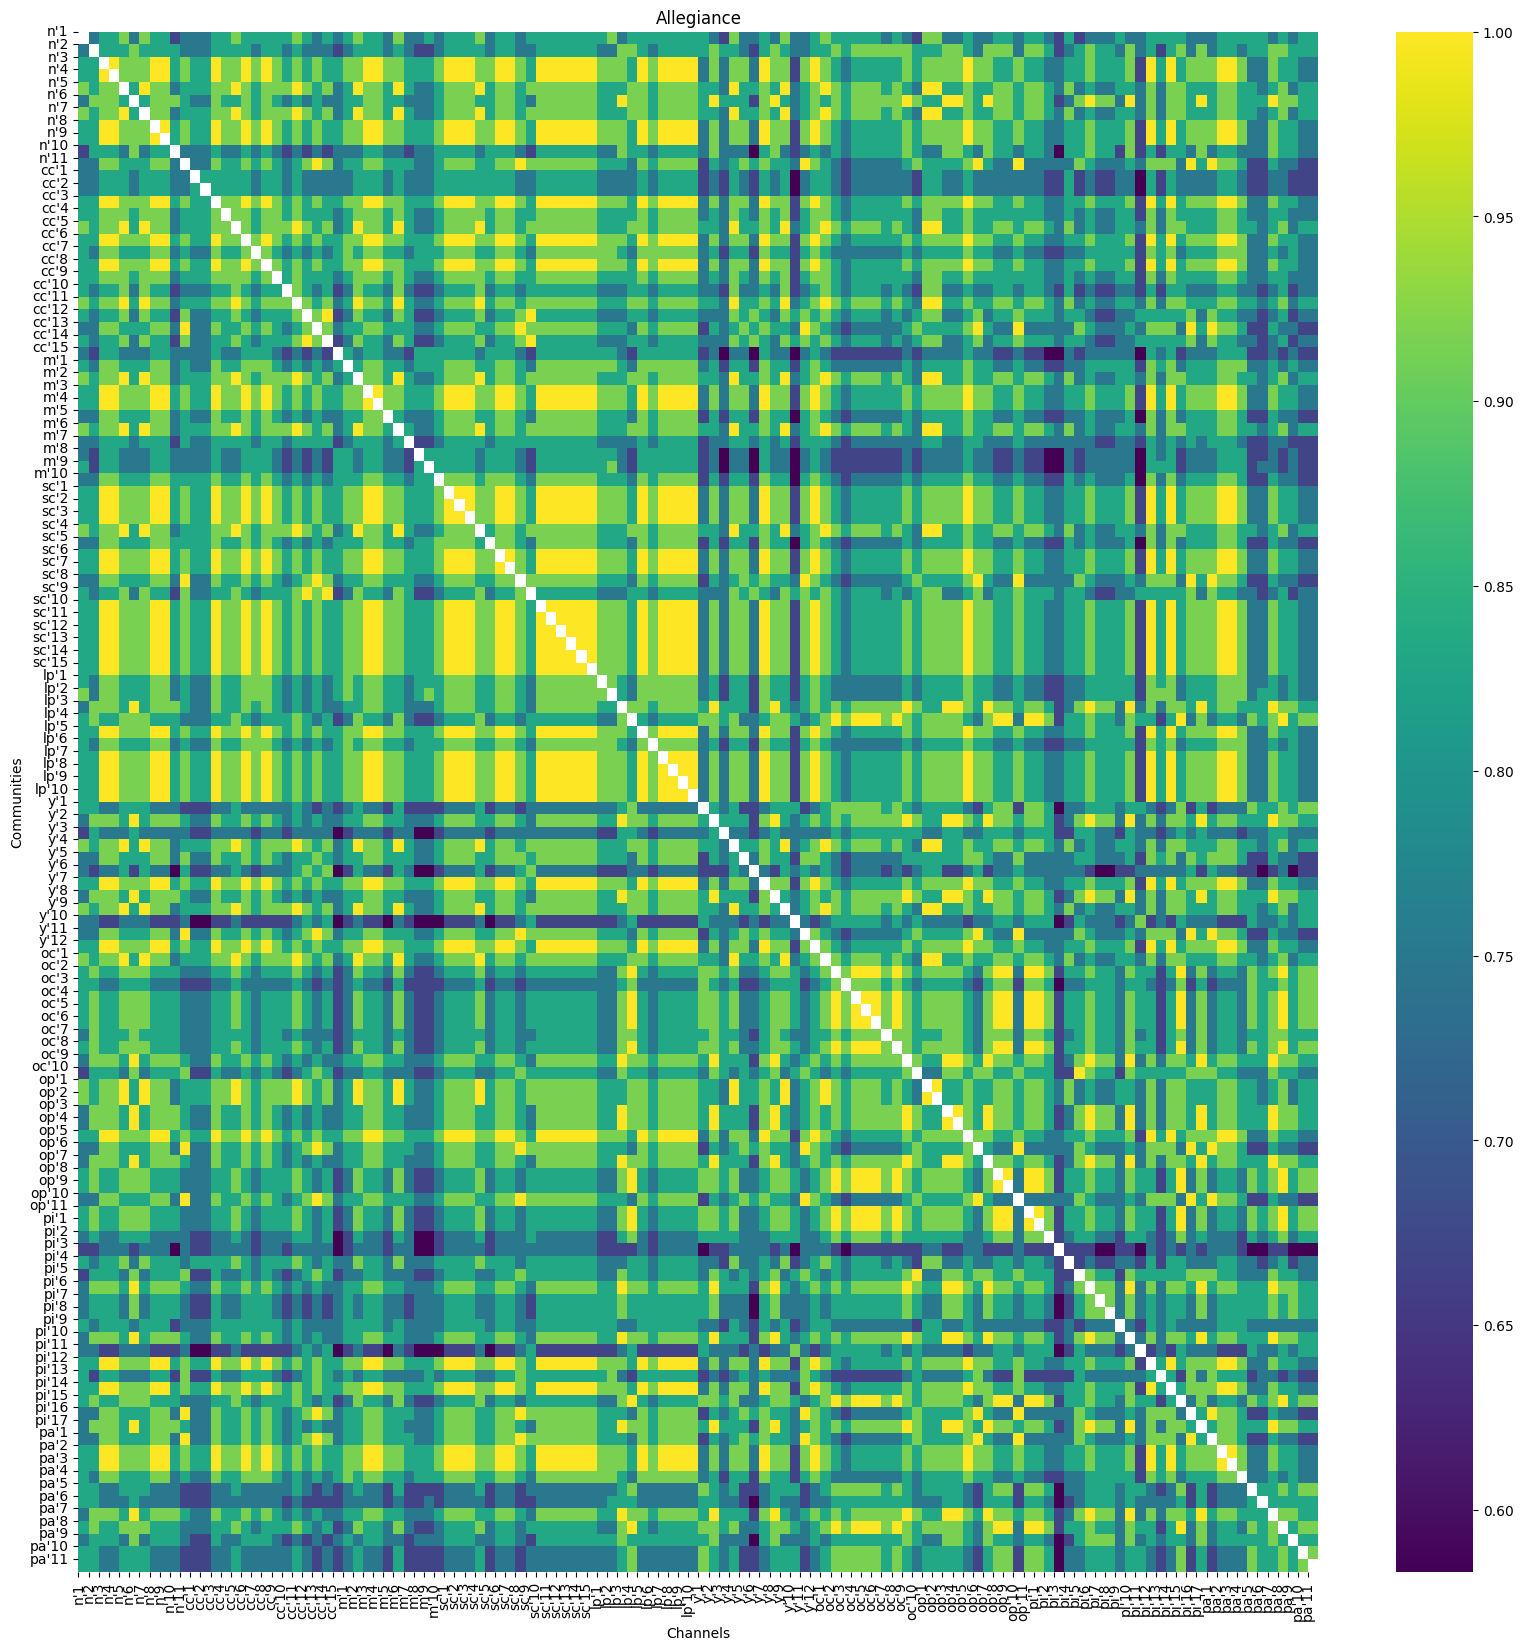

In [72]:
allegiance_m=teneto.communitymeasures.allegiance(communities_after)
plt.figure(figsize=(20,20))
sns.heatmap(allegiance_m,cmap='viridis')
plt.title('Allegiance')
plt.xlabel('Channels')
plt.ylabel('Communities')
plt.yticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1), xyz_loc['formatted_label'].values)
plt.xticks(np.arange(0, len(xyz_loc['formatted_label'].values), 1), xyz_loc['formatted_label'].values)
plt.show()